In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

means_data = pd.read_csv("Data/mean_matrix.csv")

wages = means_data[means_data["alder"] <= 61]["hourly_salary_Mean"].to_numpy()
hours = means_data[means_data["alder"] <= 61]["yearly_hours_Mean"].to_numpy() / 1924


In [18]:
def sum_hours(t, hours, delta):
    total = 0
    for i in range(t):
        total += (1 - delta) ** i * hours[t - i - 1]
    return total

def objective_function(params, wages, hours):
    w, k0, beta1, beta2, delta, k0_var = params
    total_error = 0
    for t in range(len(wages)):
        error_mean = (
            np.log(wages[t])
            - np.log(w)
            - beta1 * (1 - delta) ** t * k0
            - beta1 * (sum_hours(t, hours, delta))
            - beta2 * t**2
        )

        np.random.seed(2025)
        # k_init = np.random.uniform(low=0, high=k0*2, size=1000)
        k_init = np.clip(np.random.normal(loc=k0, scale=k0_var, size=10000), 0, None)

        error_var = (
            4311.293880288758 - np.var(np.exp(np.log(w) + beta1*k_init))
        )
        total_error += error_mean **2 + (error_var / 100) ** 2
    return total_error

initial_guess = [121.875428, 5.408275, 0.096669, -0.000183, 0.100980, 2.5]
bounds = [(0, 200), (2, 10), (0, 1), (-10, 0), (0, 0.30), (0, 6)]

def random_initial_guess(bounds):
    # np.random.seed(1)
    return [np.random.uniform(low, high) for low, high in bounds]

# initial_guess = random_initial_guess(bounds)


result = minimize(
    objective_function,
    x0=initial_guess,
    args=(wages, hours),
    method="nelder-mead",
    bounds=bounds,
    tol=1e-12,
    options={
        "maxiter": 10000,  # Maximum iterations
        "xatol": 1e-12,
        "fatol": 1e-12, 
        "disp": True
    }
)


estimated_params = result.x
w_est, k0_est, beta1_est, beta2_est, delta_est, k0_var_est = estimated_params

results_dict = {
    "Parameter": ["par.w_0 =",  "par.k_0 =", "par.beta_1 =", "par.beta_2 =", "par.delta =", "par.k_0_var ="],
    "Estimated Value": [w_est, k0_est, beta1_est, beta2_est, delta_est, k0_var_est],
}

results_df = pd.DataFrame(results_dict)

print(results_df)

print(result.fun)

       Parameter  Estimated Value
0      par.w_0 =       140.656137
1      par.k_0 =         4.992511
2   par.beta_1 =         0.076372
3   par.beta_2 =        -0.000184
4    par.delta =         0.094568
5  par.k_0_var =         4.046877
0.0014528026668110732


C:\Users\B465929\AppData\Local\Temp\ipykernel_1588\615439968.py:39: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


In [9]:
k_init = np.random.uniform(low=0, high=k0_est*2, size=10000)

np.var(np.exp(np.log(w_est) + beta1_est*k_init))

4097.395006448498

In [8]:
np.log(w_est) + beta1_est * (1 - delta_est) ** 0 * k0_est + beta1_est * (sum_hours(0, hours[0], delta_est))

5.3364719444112865

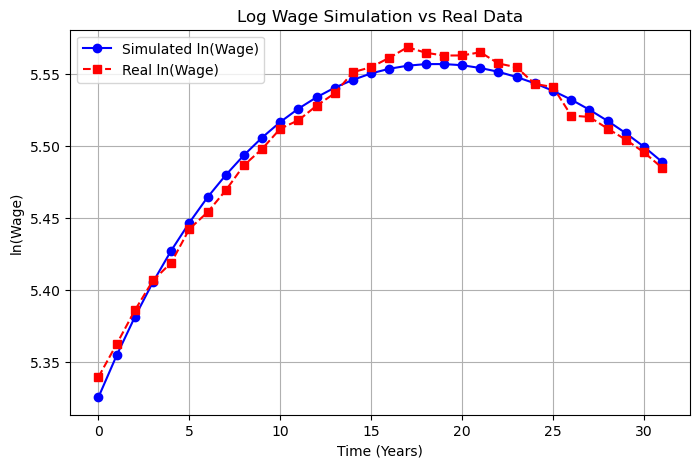

In [16]:
def simulate(params, wages, hours):
    w, k0, beta1, beta2, delta, k0_var = params
    ln_wage = np.zeros(len(wages))
    for t in range(len(wages)):
        ln_wage[t] = (
            np.log(w)
            + beta1 * (1 - delta) ** t * k0
            + beta1 * (sum_hours(t, hours, delta))
            + beta2 * t**2
        )

    return ln_wage


ln_wage = simulate(estimated_params, wages, hours)


import matplotlib.pyplot as plt

def plot_ln_wage(ln_wage, man_hourly_salary, title="Log Wage Simulation vs Real Data", 
                 xlabel="Time (Years)", ylabel="ln(Wage)"):
    plt.figure(figsize=(8, 5))
    
    # Convert real hourly salary to log scale for comparison
    ln_real_wage = np.log(man_hourly_salary)
    
    # Plot simulated ln_wage
    plt.plot(ln_wage, marker="o", linestyle="-", label="Simulated ln(Wage)", color='b')
    
    # Plot real ln(wage)
    plt.plot(ln_real_wage, marker="s", linestyle="--", label="Real ln(Wage)", color='r')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_ln_wage(ln_wage, wages)

In [ ]:

variance_matrix = pd.read_csv('Data/variance_matrix_30.csv')

salary_variance = variance_matrix.loc[variance_matrix['_NAME_'] == 'hourly_salary', 'hourly_salary'].values[0]

def objective_variance(x, salary_variance):
    np.random.seed(2025)
    samples = np.random.uniform(low=0, high=x, size=1000)
    return (salary_variance - np.var(np.exp(samples))) ** 2

result = minimize(
    objective_variance,
    x0=10,
    args=(salary_variance),
    method="Nelder-Mead",
    bounds=[(0,10)]
)

In [97]:
beta1_est

0.04907599846724678

In [124]:
np.random.seed(2025)
samples = np.random.uniform(low=0, high=5.56*2, size=100000)
np.var(np.exp(beta1_est * samples))

0.01873013156136112

In [125]:
np.var(samples)

10.29614427520932

In [ ]:
wage(par, sim_k[i,t], t)

In [122]:
np.var(sim.k_init)

NameError: name 'sim' is not defined